#### **ClinVar** 

1. Fetch
2. Get information
3. filter by pathogenicity

In [104]:
from Bio import Entrez
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

Entrez.email = "jasovicluka1@gmail.com"
search_handle = Entrez.esearch(db="clinvar", term="BRCA1", retmax=100)
search_results = Entrez.read(search_handle)
search_handle.close()
search_results

{'Count': '64849', 'RetMax': '100', 'RetStart': '0', 'IdList': ['3896363', '3896237', '3896107', '3895922', '3895907', '3895750', '3895506', '3894514', '3894494', '3894434', '3894417', '3894354', '3894344', '3894339', '3894334', '3894329', '3894319', '3894302', '3894301', '3894296', '3894295', '3894294', '3894248', '3894211', '3894190', '3894156', '3894130', '3894122', '3894082', '3894076', '3894048', '3894000', '3893999', '3893954', '3893951', '3893940', '3893939', '3893932', '3893921', '3893909', '3893890', '3893875', '3893816', '3893815', '3893795', '3893787', '3893786', '3893780', '3893764', '3893744', '3893732', '3893730', '3893678', '3893677', '3893675', '3893672', '3893340', '3893249', '3893035', '3893034', '3893017', '3893016', '3893015', '3893014', '3893013', '3893012', '3893011', '3893009', '3893008', '3893007', '3893006', '3893005', '3893004', '3892994', '3892993', '3892992', '3892991', '3892990', '3892955', '3892902', '3892167', '3891418', '3891414', '3891336', '3891335', '

In [57]:
ids = search_results["IdList"]
print(f"Found {len(ids)} ClinVar records for BRCA1")
print(f"Fetching details for IDs: {ids}")

Found 5 ClinVar records for BRCA1
Fetching details for IDs: ['3896363', '3896237', '3896107', '3895922', '3895907']


### Using esummary to get structured data since efetch is returning __HTML__ instead of  **XML** for these variations IDs.

In [61]:
summary_handle = Entrez.esummary(db="clinvar", id=",".join(ids), retmode="xml")
summary_data = Entrez.read(summary_handle)
summary_handle.close()

### Fetching __BRCA1__ Variant details 

- fetch first five only to avoid the overload

- retmax set to 100 just in case if I need more later

In [64]:
for record in summary_data["DocumentSummarySet"]["DocumentSummary"]:
    variation_id = record.attributes["uid"]
    title = record.get("title", "N/A")
    clinical_significance = record.get("clinical_significance", "N/A")
    condition_list = record.get("condition_list", "N/A")

    print(f"ID: {variation_id}")
    print(f"Title: {title}")
    print(f"Clinical Significance: {clinical_significance}")
    print(f"Conditions: {condition_list}")
    print("-" * 40)

ID: 3896363
Title: NC_000013.10:g.(32899322_32900237)_(32900751_32903579)del
Clinical Significance: N/A
Conditions: N/A
----------------------------------------
ID: 3896237
Title: NC_000013.10:g.(32929426_32930564)_(32930747_32931878)del
Clinical Significance: N/A
Conditions: N/A
----------------------------------------
ID: 3896107
Title: NM_007294.4(BRCA1):c.2309_2311delinsGAC (p.Ser770_Leu771delinsTer)
Clinical Significance: N/A
Conditions: N/A
----------------------------------------
ID: 3895922
Title: NM_000059.4(BRCA2):c.126dup (p.Asn43Ter)
Clinical Significance: N/A
Conditions: N/A
----------------------------------------
ID: 3895907
Title: NM_007194.4(CHEK2):c.106del (p.Gln36fs)
Clinical Significance: N/A
Conditions: N/A
----------------------------------------


In [96]:
for record in summary_data["DocumentSummarySet"]["DocumentSummary"]:
    variation_id = record.attributes["uid"]
    title = record.get("title", "N/A")

    # Get pathogenicity from germline_classification
    classification = record.get("germline_classification", {})
    pathogenicity = classification.get("description", "")

    # Only print if classified as Pathogenic (or similar)
    if "pathogenic" in pathogenicity.lower():
        conditions = classification.get("trait_set", [])
        condition_names = [trait.get("trait_name", "N/A") for trait in conditions]

        print(f"ID: {variation_id}")
        print(f"Title: {title}")
        print(f"Pathogenicity: {pathogenicity}")
        print(f"Conditions: {', '.join(condition_names)}")
        print("-" * 40)


ID: 3896363
Title: NC_000013.10:g.(32899322_32900237)_(32900751_32903579)del
Pathogenicity: Pathogenic
Conditions: Hereditary breast ovarian cancer syndrome
----------------------------------------
ID: 3896237
Title: NC_000013.10:g.(32929426_32930564)_(32930747_32931878)del
Pathogenicity: Pathogenic
Conditions: Hereditary breast ovarian cancer syndrome
----------------------------------------
ID: 3896107
Title: NM_007294.4(BRCA1):c.2309_2311delinsGAC (p.Ser770_Leu771delinsTer)
Pathogenicity: Pathogenic
Conditions: Hereditary breast ovarian cancer syndrome
----------------------------------------
ID: 3895922
Title: NM_000059.4(BRCA2):c.126dup (p.Asn43Ter)
Pathogenicity: Pathogenic
Conditions: Hereditary breast ovarian cancer syndrome
----------------------------------------
ID: 3895907
Title: NM_007194.4(CHEK2):c.106del (p.Gln36fs)
Pathogenicity: Pathogenic
Conditions: Hereditary breast ovarian cancer syndrome
----------------------------------------


In [100]:
def fetch_variants(gene, filter_significance=None):
    search_term = f"{gene}[Gene]"
    handle = Entrez.esearch(db="clinvar", term=search_term, retmax=50)
    result = Entrez.read(handle)
    handle.close()
    ids = result["IdList"]

    if not ids:
        print(f"No ClinVar variants found for {gene}")
        return []

    handle = Entrez.esummary(db="clinvar", id=",".join(ids), retmode="xml")
    summary = Entrez.read(handle)
    handle.close()

    variant_data = []

    for record in summary["DocumentSummarySet"]["DocumentSummary"]:
        uid = record.attributes["uid"]
        classification = record.get("germline_classification", {})
        significance = classification.get("description", "Unknown")
        traits = classification.get("trait_set", [])
        condition_names = [trait.get("trait_name", "N/A") for trait in traits]
        conditions = ", ".join(condition_names)
        date = classification.get("last_evaluated", "N/A")

        if filter_significance and filter_significance.lower() not in significance.lower():
            continue

        variant_data.append({
            "ID": uid,
            "Gene": gene,
            "Pathogenicity": significance,
            "Conditions": conditions,
            "LastEvaluated": date
        })

    return variant_data

variants = fetch_variants("BRCA1")
print(variants)



[{'ID': '3896107', 'Gene': 'BRCA1', 'Pathogenicity': 'Pathogenic', 'Conditions': 'Hereditary breast ovarian cancer syndrome', 'LastEvaluated': '2025/03/19 00:00'}, {'ID': '3895750', 'Gene': 'BRCA1', 'Pathogenicity': 'Pathogenic', 'Conditions': 'Hereditary breast ovarian cancer syndrome', 'LastEvaluated': '2025/03/10 00:00'}, {'ID': '3894514', 'Gene': 'BRCA1', 'Pathogenicity': 'Uncertain significance', 'Conditions': 'Hereditary cancer-predisposing syndrome', 'LastEvaluated': '2024/07/29 00:00'}, {'ID': '3894329', 'Gene': 'BRCA1', 'Pathogenicity': 'Uncertain significance', 'Conditions': 'Hereditary cancer-predisposing syndrome', 'LastEvaluated': '2024/04/29 00:00'}, {'ID': '3894319', 'Gene': 'BRCA1', 'Pathogenicity': 'Uncertain significance', 'Conditions': 'Hereditary cancer-predisposing syndrome', 'LastEvaluated': '2024/04/03 00:00'}, {'ID': '3894302', 'Gene': 'BRCA1', 'Pathogenicity': 'Uncertain significance', 'Conditions': 'Hereditary cancer-predisposing syndrome', 'LastEvaluated': '2

### Variance significance distribution simple barplot 

Saved plot to MSTN_variant_significance.png


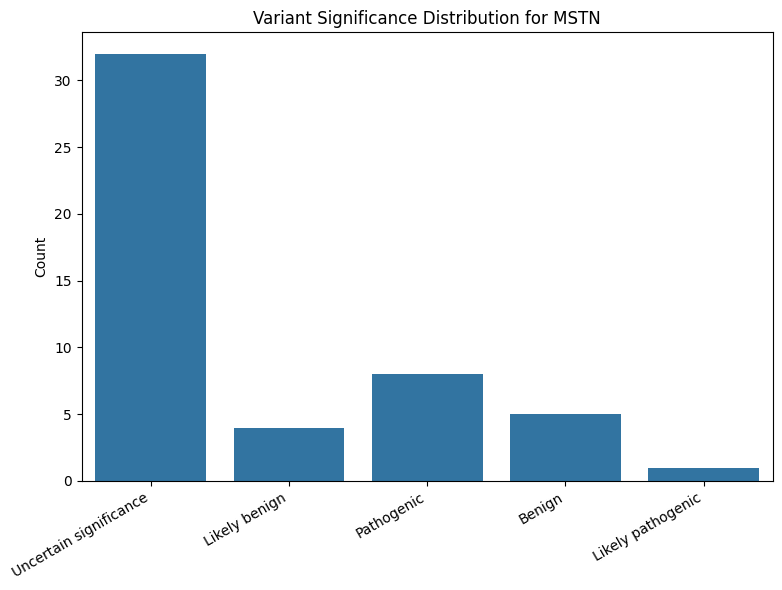

In [ ]:
def plot_significance_distribution(variants, gene):
    sigs = [v["Pathogenicity"] for v in variants]
    count = Counter(sigs)  # Use collections.Counter to count occurrences

    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(count.keys()), y=list(count.values()))
    plt.title(f"Variant Significance Distribution for {gene}")
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha='right') # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.savefig(f"{gene}_variant_significance.png")
    print(f"Saved plot to {gene}_variant_significance.png")
    plt.show()

variants = fetch_variants("MSTN")
plot_significance_distribution(variants, "MSTN")

### Further analyiss will include allele frequencies, retrieval with GMAF.